## Modules

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, ticker
import seaborn as sns
import os
import geopandas
import cartopy.crs as ccrs
import cartopy
import numpy as np
import shapely
import statsmodels.api as sma

## Paths

In [12]:
WILDCARDS = ["all", "chromosome", "full", "30"]
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

CURRENT_YEAR = 2021
BURNIN = 0.1

# ------------------------------------------
# Geo
CRS = "epsg:3857"
#CRS_EPSG = ccrs.epsg('3857')
#world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

pd.set_option("display.max_rows", 10, "display.max_columns", None)

np.random.seed(1235423134)

NO_DATA_CHAR = "NA"
ALPHA = 0.05

# ------------------------------------------
# Geo
CRS = "epsg:3857"
CRS_EPSG = ccrs.epsg('3857')
world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

In [13]:
site_path       = project_dir + "metadata/{}/site_metadata.txt".format(READS_ORIGIN)
individual_path       = project_dir + "metadata/{}/individual_metadata.txt".format(READS_ORIGIN)
beast_log_path      = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/beast_log.tsv".format(READS_ORIGIN, MISSING_DATA)
out_dir             = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/".format(READS_ORIGIN, MISSING_DATA)

## Metadata

### Site

In [14]:
site_df = pd.read_csv(site_path, sep="\t", encoding="latin-1")
site_df.sort_values("start_date", inplace=True)
display(site_df)

,name,region,code,n,plague_positive_n,plague_positive_perc,start_date,end_date,lat,lon
0,Ribe Gräbrødre,Ribe,ASR 1015,51,5,10%,1150,1550,55.328117,8.757698
2,Nordby,Viby,FHM 3970,36,0,0%,1150,1349,56.076086,10.207652
6,Hågerup,Hågerup,ØHM 1247,7,1,14%,1150,1349,55.157110,10.345347
9,Sct. Drotten,Viborg,VSM 09264/VSM 902F,14,0,0%,1150,1349,56.451264,9.394534
10,Sct. Mathias,Viborg,VSM 855F/906F,23,0,0%,1150,1550,56.451264,9.394534
...,...,...,...,...,...,...,...,...,...,...
3,Ole Wormsgade,Horsens,HOM 1649,17,2,12%,1250,1449,55.860573,9.847695
4,Sejet,Horsens,HOM 1046,25,1,4%,1250,1449,55.860573,9.847695
5,Tirup,Horsens,VKH 1201,11,1,9%,1250,1449,55.860573,9.847695
7,Refshale,Refshale,Refshale,19,0,0%,1250,1449,54.763377,11.490075


### Individual

In [15]:
individual_df = pd.read_csv(individual_path, sep="\t", encoding="latin-1")
individual_df.sort_values("start_date", inplace=True)
display(individual_df)

,arch_id,project_id,julia_id,site_code,arm_position,time_period,start_date,end_date,end_date_orig,HP ID,Plague PCR Status
151,X,P162,120.0,FHM 3970,Pre,1,1150,1349,1325,HP2545,Negative
136,G341,P147,4.0,ASR 1015,Pre,1,1150,1349,1325,HP2530,Negative
135,G262,P146,5.0,ASR 1015,Pre,1,1150,1349,1325,HP2529,Negative
134,CE,P145,102.0,FHM 3970,Pre,1,1150,1349,1325,HP2528,Negative
133,DM,P144,112.0,FHM 3970,Pre,1,1150,1349,1325,HP2527,Negative
...,...,...,...,...,...,...,...,...,...,...,...
100,A2516 X2460,D94a,192.0,HOM 1272,Post-Medieval,4,1600,1800,1800,HP4261,Negative
101,A2521 X2475,D95a,193.0,HOM 1272,Post-Medieval,4,1600,1800,1800,HP4262,Negative
102,A2545 X2533,D96a,197.0,HOM 1272,Post-Medieval,4,1600,1800,1800,HP4268,Negative
95,A2437 X2140,D89a,169.0,HOM 1272,Post-Medieval,4,1600,1800,1800,HP4243,Negative


### Tip Dates

In [16]:
log_df = pd.read_csv(beast_log_path, sep="\t", index_col="Sample")

# Discard burnin
burnin_states = round(len(log_df) * BURNIN)
log_df = log_df.iloc[burnin_states:]


danish_samples = {
    "D62" : "G25A",    
    "D71" : "G16", 
    "R36" : "G25B x98",    
    "P387" : "A1480 x1480",
    "P187" : "A146 x3011",    
    "P212" : "G371",
    "D72" : "G207",     
    "D75" : "G861 x1035",         
    "D51" : "Gr GC 15" ,    
    
}
columns = ["height({})".format(sample) for sample in danish_samples]
danish_tip_df = log_df[columns]

# Convert to calendar year
for col in danish_tip_df:
    bp_years = list(danish_tip_df[col])
    calendar_years = [CURRENT_YEAR - year for year in bp_years]
    danish_tip_df[col] = calendar_years

danish_tip_df.columns = list(danish_samples.values())

# Find oldest sample
danish_min_mean = CURRENT_YEAR
danish_max_mean = -CURRENT_YEAR

for column in danish_tip_df:
    mean_date = sum(danish_tip_df[column]) / len(danish_tip_df[column])
    if mean_date < danish_min_mean:
        danish_min_mean = mean_date
    if mean_date > danish_max_mean:
        danish_max_mean = mean_date
        
danish_violin_df = pd.DataFrame({"sample": [], "date": [], })
for column in danish_tip_df.columns:
    dates = list(danish_tip_df[column])
    samples = [column] * len(dates) 
    data_df = pd.DataFrame({"date" : dates, "sample" : samples})
    danish_violin_df = danish_violin_df.append(data_df, ignore_index=True)
    
display(danish_violin_df)

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sample,date
0,G25A,1338.441152
1,G25A,1332.452364
2,G25A,1331.330174
3,G25A,1335.245927
4,G25A,1339.298081
...,...,...
81004,Gr GC 15,1533.149099
81005,Gr GC 15,1547.053682
81006,Gr GC 15,1561.594769
81007,Gr GC 15,1543.595057


### CI

In [17]:
confidence = 95
adjust = (100 - confidence)/2
ci = [0 + adjust, 100 - adjust]
date_ci_min = 10000
date_ci_max = 0

for sample in danish_samples.values():
    df = danish_violin_df[danish_violin_df["sample"] == sample]
    date_ci = np.array(
        np.percentile(
            np.array(list(df["date"])),
            ci,
            axis=0,
        )
    )
    if date_ci[0] < date_ci_min:
        date_ci_min = date_ci[0]
    if date_ci[1] > date_ci_max:
        date_ci_max = date_ci[1]
    
    #kde = sma.nonparametric.KDEUnivariate(list(df["date"]))
    #kde.fit()
    #peak_i = np.argmax(kde.density)
    #peak = kde.support[peak_i]
    
print(date_ci_min, date_ci_max)

1293.6186763403416 1661.5375087012046


---

# Plot

(1050.0, 1850.0)

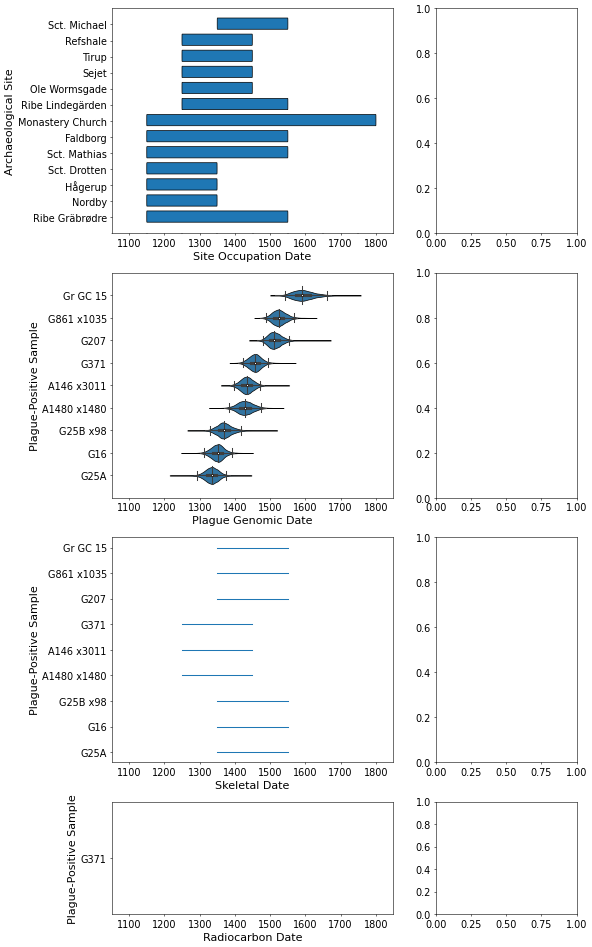

In [63]:
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
FIGSIZE=[12,24]
## All
fig, axes = plt.subplots(4,2,figsize=FIGSIZE, dpi=DPI,
                        gridspec_kw={
                            'height_ratios': [1, 1, 1, 0.5],
                            'width_ratios': [1, 0.5,]
                        
                        }
                        )


# ---------------------------------------
# Site Timeline

ax = axes[0][0]


xbuff = 100
xticks = list(range(
    min(site_df["start_date"])- xbuff, 
    max(site_df["end_date"]) + xbuff, 
    100)
)
yticks = {}

i = 0
for rec in site_df.iterrows():
    site = rec[1]["name"]
    start_date = rec[1]["start_date"]
    end_date = rec[1]["end_date"]
    n = rec[1]["n"]
    yticks[i] = site
    
    color="#1f77b4" # blue
    bar = patches.FancyBboxPatch(
        xy     = (start_date, i),
        width  = end_date - start_date, 
        height = 0.1,
        boxstyle = "round",
        ec = "black",
        color=color,
    )
    ax.add_patch(bar)
    i += 1

# Tick Labels
ax.set_xlim(xticks[0], xticks[-1])
ax.set_xticks(xticks)
ax.set_yticks(list(yticks.keys()))
ax.set_yticklabels(list(yticks.values()))

# Tickers
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))

# Limits
ax.set_ylim(-1,len(site_df))

# Labels
ax.set_xlabel("Site Occupation Date", fontsize=FONTSIZE+2)
ax.set_ylabel("Archaeological Site", fontsize=FONTSIZE+2)
#ax.xaxis.set_label_position('top') 
#ax.xaxis.tick_top()


# ---------------------------------------
# Genomic Dates
ax = axes[1][0]

sns.violinplot(
    ax=ax, 
    data=danish_violin_df, 
    x="date", 
    y="sample", 
    color="#1f77b4", #blue
    #inner=None, 
    zorder=1,
    label="Test",
)
sns.boxplot(
    ax=ax, 
    data=danish_violin_df, 
    x="date", 
    y="sample", 
    showfliers=False, 
    showbox=False, 
    whis=ci,
    zorder=2,
)

ax.set_ylabel("Plague-Positive Sample", fontsize=FONTSIZE + 2)
ax.set_xlabel("Plague Genomic Date", fontsize=FONTSIZE+2)
# Custom styles
#ax.set_yticklabels(list(danish_tip_df.columns))
for collection in ax.collections:
    collection.set_linewidth(1)
    collection.set_edgecolor("black")
ax.set_ylim(-1, len(danish_samples))
ax.set_xlim(1050, 1850)

# ---------------------------------------
# Skeletal Dates
ax = axes[2][0]

yticks = {}

i = -0.5
for sample in danish_samples.keys():
    sample_df = individual_df[individual_df["project_id"].str.contains(sample)]
    x = list(sample_df["start_date"]) + list(sample_df["end_date"])
    y = [i,i]
    yticks[i] = danish_samples[sample]
    ax.plot(x,y, color="#1f77b4", )
    i += 1
    
ax.set_ylabel("Plague-Positive Sample", fontsize=FONTSIZE + 2)
ax.set_xlabel("Skeletal Date", fontsize=FONTSIZE+2)
#ax.set_xlim(xticks[0], xticks[-1])
#ax.set_xticks(xticks)
ax.set_yticks(list(yticks.keys()))
ax.set_yticklabels(list(yticks.values()))
ax.set_xlim(1050, 1850)

# ---------------------------------------
# Radiocarbon

ax = axes[3][0]
ax.set_xlabel("Radiocarbon Date", fontsize=FONTSIZE+2)
ax.set_ylabel("Plague-Positive Sample", fontsize=FONTSIZE + 2)
ax.set_ylim(-0.5,0.5)
ax.set_yticks([0])
ax.set_yticklabels(["G371"])
ax.set_xlim(1050, 1850)



Text(0.5, 1.0, 'gs[-1, -2]')

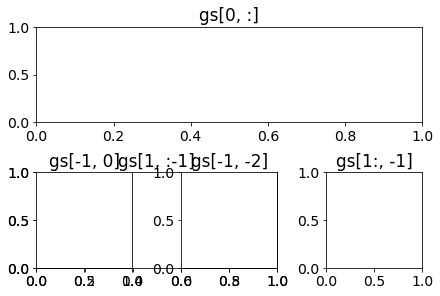

In [75]:
figsize=[6,6]

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax1.set_title('gs[0, :]')
ax2 = fig.add_subplot(gs[1, :-1])
ax2.set_title('gs[1, :-1]')
ax3 = fig.add_subplot(gs[1:, -1])
ax3.set_title('gs[1:, -1]')
ax4 = fig.add_subplot(gs[-1, 0])
ax4.set_title('gs[-1, 0]')
ax5 = fig.add_subplot(gs[-1, -2])
ax5.set_title('gs[-1, -2]')

In [ ]:
xbuff = 50
xticks = list(range(
    min(individual_df["start_date"])- xbuff, 
    max(individual_df["end_date"]) + xbuff, 
    100)
)

cdf = {}
for d in range(xticks[0], xticks[-1] + 1, 1):
    cdf[d] = 0
    
for rec in individual_df.iterrows():
    start_date = rec[1]["start_date"]
    end_date = rec[1]["end_date"]
    range_date = end_date - start_date
    p = 1 / range_date
    for d in range(start_date, end_date + 1, 1):
        cdf[d]+= p
    
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
FIGSIZE=[12,6]
## All
fig, axes = plt.subplots(1,1,figsize=FIGSIZE, dpi=DPI)

ax = axes

sns.lineplot(
    ax=ax,
    x=list(cdf.keys()),
    y=list(cdf.values()),
)

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=100
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

# Setup figure and axis
num_sites = len(set(site_df["name"]))
fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI, sharex=True)
fig.subplots_adjust(hspace=0)

xticks = list(range(min(site_df["date_start"]),max(site_df["date_end"]) + 100, 100))
yticks = {}


# If multiple plots
if type(axes) == np.ndarray:
    ax = axes[0]
else:
    ax = axes
    
i = 1
prev_site = ""
for rec in site_df.iterrows():
    site = rec[1]["name"]
    if site != prev_site:
        yticks[i] = site
    else:
        yticks[i] = ""
        
        
    n = rec[1]["n"]
    print(i,n)
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    
    date_mean = sum([date_start, date_end] ) / 2
    date_err = date_end - date_mean
    y_coord = rec[1]["number"]
       
    color="#1f77b4" # blue
    ax.add_patch(patches.FancyBboxPatch(
        #xy     = (date_start, y_coord), 
        xy     = (date_start, i),
        width  = date_end - date_start, 
        #height = 0.10,
        height = -n,
        boxstyle = "round",
        ec = "black",
        color=color,
    )) 
    prev_site = site
    #i -= 1
    i -= n * 2
    


ax.set_xlabel("Date", fontsize=FONTSIZE * 0.75)
ax.set_xlim(min(site_df["date_start"])-50,max(site_df["date_end"]) + 100)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=FONTSIZE / 2)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
#ax.set_yticks(yticks)
#ax.set_yticklabels(list(range(0, len(yticks))), fontsize=FONTSIZE / 2)

ax.set_ylim(0 - len(yticks),3)
print(yticks)
ax.set_yticks(list(yticks.keys()))
ax.set_yticklabels(list(yticks.values()))
#print(list(yticks.values()))
#ax.set_yticklabels(list(yticks.values()))



In [ ]:
site_df = pd.read_csv(metadata_path, sep="\t", encoding="latin-1")
#site_df.sort_values(by="date_start", inplace=True)

# Add site numbering
site_dict = {}
site_numbers = []
site_i = 0

for rec in site_df.iterrows():
    site_code = rec[1]["code"]
    if site_code not in site_dict:
        site_i += 1
        number = site_i
        site_dict[site_code] = site_i
    else:
        number = site_dict[site_code] 
    site_numbers.append(number)
    
    if rec[1]["positive"] > 0:
        site_df.at[rec[0],"positive_color"] = "#ff7f0e"
    else:
        site_df.at[rec[0],"positive_color"] = "#1f77b4"

site_df["number"] = site_numbers
site_df.fillna("NA", inplace=True)
site_df = site_df[site_df["date_start"] != "NA"]

# Convert to int
site_df["date_start"] = [int(date) for date in site_df["date_start"]]
site_df["date_end"] = [int(date) for date in site_df["date_end"]]
display(site_df)


## BEAST Log

In [ ]:
log_df = pd.read_csv(beast_log_path, sep="\t", index_col="Sample")

# Discard burnin
burnin_states = round(len(log_df) * BURNIN)
log_df = log_df.iloc[burnin_states:]


danish_samples = {
    "D62" : "G25A",    
    "D71" : "G16", 
    "R36" : "G25B x98",    
    "P387" : "A1480 x1480",
    "P187" : "A146 x3011",    
    "P212" : "G371",
    "D72" : "G207",     
    "D75" : "G861 x1035",         
    "D51" : "Gr GC 15" ,    
    
}
columns = ["height({})".format(sample) for sample in danish_samples]
danish_tip_df = log_df[columns]

# Convert to calendar year
for col in danish_tip_df:
    bp_years = list(danish_tip_df[col])
    calendar_years = [CURRENT_YEAR - year for year in bp_years]
    danish_tip_df[col] = calendar_years

danish_tip_df.columns = list(danish_samples.values())

# Find oldest sample
danish_min_mean = CURRENT_YEAR
danish_max_mean = -CURRENT_YEAR

for column in danish_tip_df:
    mean_date = sum(danish_tip_df[column]) / len(danish_tip_df[column])
    if mean_date < danish_min_mean:
        danish_min_mean = mean_date
    if mean_date > danish_max_mean:
        danish_max_mean = mean_date
        
danish_violin_df = pd.DataFrame({"sample": [], "date": [], })
for column in danish_tip_df.columns:
    dates = list(danish_tip_df[column])
    samples = [column] * len(dates) 
    data_df = pd.DataFrame({"date" : dates, "sample" : samples})
    danish_violin_df = danish_violin_df.append(data_df, ignore_index=True)

---

# 2. Plot

## Intersection

In [ ]:
min_date = min(site_df["date_start"])
max_date = max(site_df["date_end"])
interval_date = 1

date_n_dict = {}

for date in range(min_date, max_date + interval_date, interval_date):
    date_n_dict[date] = 0
    
    
for rec in site_df.iterrows():
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    n = rec[1]["n"]       
        
    for date in date_n_dict:        

        date_next = date + interval_date
        if date_start >= date and date_start < date_next:
            date_n_dict[date] += n

        elif date_start < date and date_end >= date:
            date_n_dict[date] += n
            
#print(date_n_dict)

## Plot

In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=100
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

# Setup figure and axis
num_sites = len(set(site_df["name"]))
fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI, sharex=True)
fig.subplots_adjust(hspace=0)

xticks = list(range(min(site_df["date_start"]),max(site_df["date_end"]) + 100, 100))
yticks = {}


# If multiple plots
if type(axes) == np.ndarray:
    ax = axes[0]
else:
    ax = axes
    
i = 1
prev_site = ""
for rec in site_df.iterrows():
    site = rec[1]["name"]
    if site != prev_site:
        yticks[i] = site
    else:
        yticks[i] = ""
    n = rec[1]["n"]
    print(i,n)
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    date_mean = sum([date_start, date_end] ) / 2
    date_err = date_end - date_mean
    y_coord = rec[1]["number"]
       
    color="#1f77b4" # blue
    ax.add_patch(patches.FancyBboxPatch(
        #xy     = (date_start, y_coord), 
        xy     = (date_start, i),
        width  = date_end - date_start, 
        #height = 0.10,
        height = -n,
        boxstyle = "round",
        ec = "black",
        color=color,
    )) 
    prev_site = site
    #i -= 1
    i -= n * 2
    


ax.set_xlabel("Date", fontsize=FONTSIZE * 0.75)
ax.set_xlim(min(site_df["date_start"])-50,max(site_df["date_end"]) + 100)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=FONTSIZE / 2)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
#ax.set_yticks(yticks)
#ax.set_yticklabels(list(range(0, len(yticks))), fontsize=FONTSIZE / 2)

ax.set_ylim(0 - len(yticks),3)
print(yticks)
ax.set_yticks(list(yticks.keys()))
ax.set_yticklabels(list(yticks.values()))
#print(list(yticks.values()))
#ax.set_yticklabels(list(yticks.values()))



In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1080, 1560]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

# Setup figure and axis
fig, axes = plt.subplots(3, figsize=FIGSIZE, dpi=DPI, sharex=True)
fig.subplots_adjust(hspace=0)

xticks = list(range(min(site_df["date_start"]),max(site_df["date_end"]) + 100, 100))

# ---------------------------------------
# Violin Plots
ax = axes[len(axes) - 1]

# Plot
sns.violinplot(
    ax=ax, 
    data=danish_violin_df, 
    x="date", 
    y="sample", 
    lw=0.5, 
    color="#1f77b4", #blue
    #olor="#ff7f0e", #orange
    inner=None, 
    zorder=2
)
ax.set_ylabel("Sample", fontsize=FONTSIZE * 0.75)
# Custom styles
ax.set_yticklabels(list(danish_tip_df.columns), fontsize=FONTSIZE / 2)
for collection in ax.collections:
    collection.set_linewidth(0.5)

# ---------------------------------------
# Line graph
ax = axes[len(axes) - 2]
    
# Plot
sns.lineplot(ax=ax, x=list(date_n_dict.keys()), y=list(date_n_dict.values()))
# Customstyles
ax.set_yticklabels([round(t) for t in ax.get_yticks()], fontsize=FONTSIZE / 2)


# ---------------------------------------
# Rect Graph
ax = axes[len(axes) - 3]

# Plot
for rec in site_df.iterrows():
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    y_coord = rec[1]["number"]
    positive = rec[1]["positive"]
       
    color="#1f77b4" # blue
    #if positive > 0:
    #    color="#ff7f0e" # orange
    ax.add_patch(patches.FancyBboxPatch(
        xy     = (date_start, y_coord), 
        width  = date_end - date_start, 
        height = 0.10,
        boxstyle = "round",
        ec = "black",
        color=color,
    ))
    
# Custom Styles
ax.set_ylabel("Site", fontsize=FONTSIZE * 0.75)
ax.set_ylim(0,max(site_df["number"]) + 1)
ax.set_ylim(-10,max(site_df["number"]) + 1)
ax.set_yticks(range(1, len(site_dict) + 1))
ax.set_yticklabels(list(site_dict.keys()), fontsize=FONTSIZE / 2)

# ---------------------------------------
# Annotations

# Bottom xaxis   
axes[-1].set_xlabel("Date", fontsize=FONTSIZE * 0.75)
axes[-1].set_xlim(min(site_df["date_start"])-50,max(site_df["date_end"]) + 100)
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels(xticks, fontsize=FONTSIZE / 2)
axes[-1].xaxis.set_minor_locator(ticker.MultipleLocator(50))


# Add vertical lines
for ax in axes:
    # Major tick lines
    for tick in xticks:
        ax.axvline(tick, lw=0.25, color="black", alpha=0.25, zorder=0)
    # High prob region
    ax.add_patch(patches.FancyBboxPatch(
        xy     = (danish_min_mean, - 10), 
        width  = danish_max_mean - danish_min_mean, 
        height = 1000,
        boxstyle = "round",
        ec = "none",
        #color="#c4c4c4", #grey
        color="#1f77b4", #blue
        #color="#ff7f0e", #orange
        alpha=0.15,
        zorder=0,
    ))   
    # Align ylabels
    ax.yaxis.set_label_coords(-0.20, 0.5)

"""out_path = os.path.join(out_dir, "site_timeline")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

---
# Mapping

In [ ]:
map_df = pd.DataFrame(columns = ["region","lon","lat","n"])
geometry = []
for region in set(site_df["region"]):
    total_n = float(sum(list(site_df[site_df["region"] == region]["n"])))
    lat = list(site_df[site_df["region"] == region]["lat"])[0]
    lon = list(site_df[site_df["region"] == region]["lon"])[0]
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)
    
    data = {"region":region, "lon":lon, "lat":lat, "n":total_n}
    map_df = map_df.append(data, ignore_index=True)


map_gdf = geopandas.GeoDataFrame(map_df, crs=CRS, geometry=geometry)
display(map_gdf)


In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},figsize=FIGSIZE, dpi=DPI)

# Basemap
ax.add_feature(cartopy.feature.LAND, edgecolor="black", lw=0.25)
ax.add_feature(cartopy.feature.OCEAN, edgecolor="black", lw=0.25)
ax.add_feature(cartopy.feature.BORDERS, lw=0.25)
ax.add_feature(cartopy.feature.LAKES, edgecolor="black", lw=0.25)
ax.add_feature(cartopy.feature.RIVERS, lw=0.25)
#ax.gridlines(draw_labels=True)

map_gdf.plot(
    ax=ax, 
    markersize="n",
    color="#ff7f0e",
    edgecolor="black",
    lw=0.25,
    transform=ccrs.PlateCarree(),
)

# Text Labels
x_buff = 0.1
for rec in map_df.iterrows():
    n = rec[1]["n"]
    lon = rec[1]["lon"] + x_buff
    lat = rec[1]["lat"]
    name = rec[1]["region"] + ", {}".format(int(n))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1.0, lw=0.25)

    # place a text box in upper left in axes coords
    #ax.text(x=lon, y=lat, s=name, transform=ccrs.PlateCarree(), fontsize=FONTSIZE / 4,
    #        verticalalignment='top', bbox=props)

# Denmark focus
ax.set_extent([7, 14, 54, 58])

for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.25)

out_path = os.path.join(out_dir, "site_map")
# Use pdf to help shrink file size
plt.savefig(out_path + ".pdf", bbox_inches="tight")
#plt.savefig(out_path + ".png", bbox_inches="tight")
#plt.savefig(out_path + ".svg", bbox_inches="tight")